# 堆疊回歸(Stacking Regressor)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import random
from random import choices
import matplotlib.pyplot as plt

# Training Data

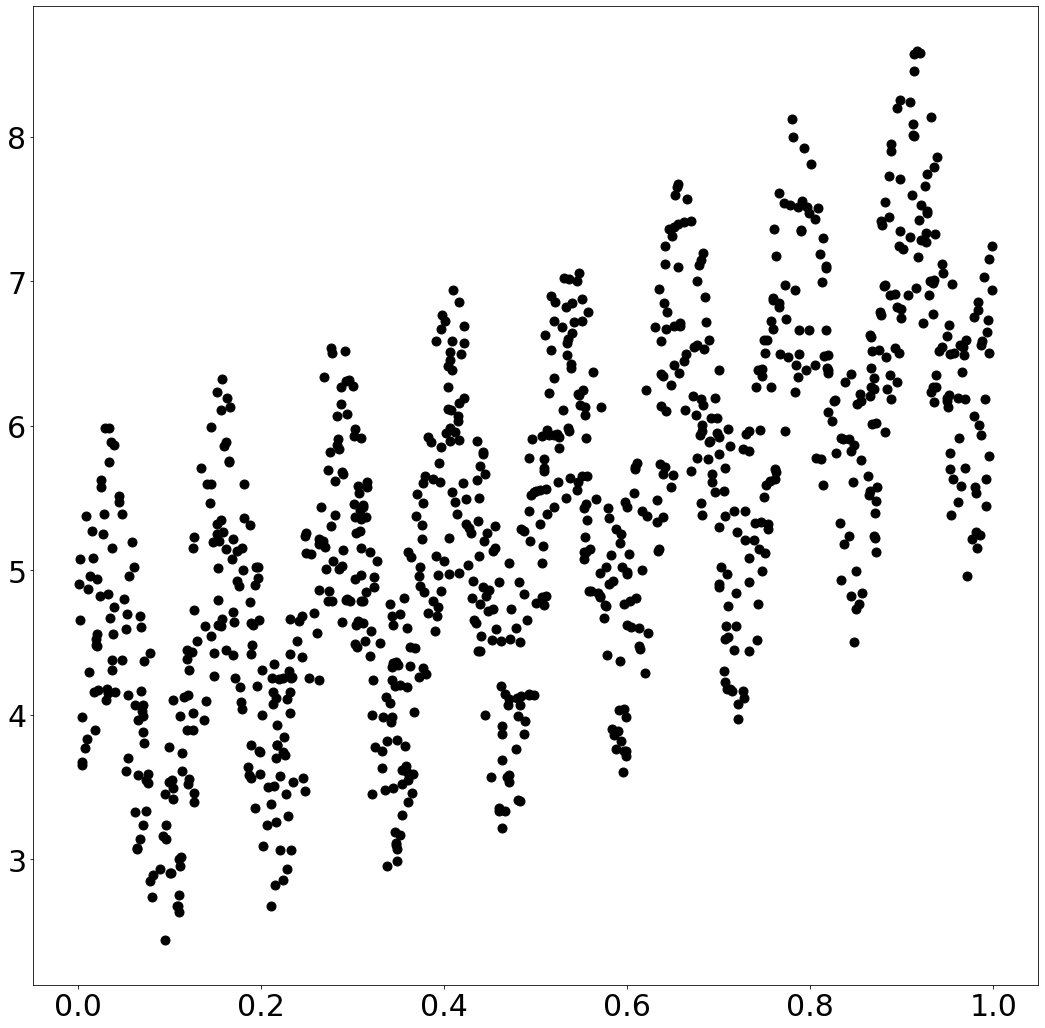

In [2]:
N=1000
p2,p1,p0=1,2,3
x=np.zeros(N)
y=np.zeros(N)
for i in range(0,len(x)):
    x[i]+=random.random()
    y[i]+=random.random()*2
power=[p2,p1,p0]
for i in range(0,len(power)):
    y+=power[len(power)-i-1]*(x**i)
y+=np.sin(x*50)
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x,y,"ko",markersize=9)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

# Testing Data

In [3]:
N_test=100
x_test=np.zeros(N_test)
y_test=np.zeros(N_test)
for i in range(0,len(x_test)):
    x_test[i]+=random.random()
    y_test[i]+=random.random()*2
power=[p2,p1,p0]
for i in range(0,len(power)):
    y_test+=power[len(power)-i-1]*(x_test**i)
y_test+=np.sin(x_test*50)

# Mean Square Error

In [4]:
def MSE(s,y,D=None):
    if(D is None):
        com=sum((y[s]-np.mean(y[s]))**2)
    else:
        com=sum(D[s]*(y[s]-np.mean(y[s]))**2)
    return com

# Decision Stump

In [5]:
def Decision_Stump(x,y,typ,D=None):
    x_sort=np.sort(x)
    x_sort_index=np.argsort(x)
    if(typ=="RF"):
        impurity=np.zeros(len(y)-1)
        for i in range(1,len(y)):
            s_left,s_right=x_sort_index[:i],x_sort_index[i:]
            impurity[i-1]=(len(s_left)/len(y))*MSE(s_left,y)+(len(s_right)/len(y))*MSE(s_right,y)
        x_split=(x_sort[np.argmin(impurity)]+x_sort[np.argmin(impurity)+1])/2
        return x_split,min(impurity)
    elif(typ=="ET"):
        num=50
        seed_split=np.random.uniform(min(x),max(x),num)
        impurity=np.zeros(num)
        for i in range(0,num):
            BOOL=x<seed_split[i]
            s_left,s_right=np.array(np.where(BOOL)).flatten(),np.array(np.where(~BOOL)).flatten()
            impurity[i]=(len(s_left)/len(y))*MSE(s_left,y)+(len(s_right)/len(y))*MSE(s_right,y)
        return seed_split[np.argmin(impurity)],min(impurity)
    elif(typ=="ABDT"):
        impurity=np.zeros(len(y)-1)
        for i in range(1,len(y)):
            s_left,s_right=x_sort_index[:i],x_sort_index[i:]
            impurity[i-1]=(len(s_left)/len(y))*MSE(s_left,y,D)+(len(s_right)/len(y))*MSE(s_right,y,D)
        x_split=(x_sort[np.argmin(impurity)]+x_sort[np.argmin(impurity)+1])/2
        return x_split,min(impurity)
    else:
        impurity=np.zeros(len(y)-1)
        min_val=np.zeros(len(x[0]))
        min_split=np.zeros(len(x[0]))
        for j in range(0,len(x[0])):
            x_sort=np.sort(x[:,j])
            x_sort_index=np.argsort(x[:,j])
            for i in range(1,len(y)):
                s_left,s_right=x_sort_index[:i],x_sort_index[i:]
                impurity[i-1]=(len(s_left)/len(y))*MSE(s_left,y)+(len(s_right)/len(y))*MSE(s_right,y)
            min_val[j]=min(impurity)
            min_split[j]=(x_sort[np.argmin(impurity)]+x_sort[np.argmin(impurity)+1])/2
        return min_split[np.argmin(min_val)],np.argmin(min_val),min(min_val)

# Decision Tree

In [6]:
def Decision_Tree(x,y,x_real,y_real,x_test,y_test,index,index_test,max_depth,y_train,y_pred,typ,D=None):
    if((D is None) and (typ!="DT")):
        x_split,impurity=Decision_Stump(x,y,typ)
        p=x<x_split
        p_real=x_real<x_split
        p_test=x_test<x_split
    elif(typ=="DT"):
        x_split,m,impurity=Decision_Stump(x,y,typ)
        p=x[:,m]<x_split
        p_real=x_real[:,m]<x_split
        p_test=x_test[:,m]<x_split
    else:
        x_split,impurity=Decision_Stump(x,y,typ,D)
        p=x<x_split
        p_real=x_real<x_split
        p_test=x_test<x_split
    x_left,y_left=x[p],y[p]
    x_right,y_right=x[~p],y[~p]
    p_real_left=np.where(p_real)
    p_real_right=np.where(~p_real)
    left_index=np.intersect1d(p_real_left,index)
    right_index=np.intersect1d(p_real_right,index)
    p_test_left=np.where(p_test)
    p_test_right=np.where(~p_test)
    left_index_test=np.intersect1d(p_test_left,index_test)
    right_index_test=np.intersect1d(p_test_right,index_test)
    
    check_left,check_right=True,True
    if(len(y_left)!=1):
        for i in range(1,len(y_left)):
            if(y_left[i]!=y_left[0]):
                check_left=False
                break
    if(len(y_right)!=1):
        for i in range(1,len(y_right)):
            if(y_right[i]!=y_right[0]):
                check_right=False
                break

    if((impurity==0)or(max_depth==0)or((check_left)and(check_right))):
        y_train[left_index],y_train[right_index]=np.mean(y_left),np.mean(y_right)
        y_pred[left_index_test],y_pred[right_index_test]=np.mean(y_left),np.mean(y_right)
        return y_train,y_pred
    elif(check_left):
        max_depth-=1
        y_train,y_pred=Decision_Tree(x_right,y_right,x_real,y_real,x_test,y_test,
                                     right_index,right_index_test,max_depth,y_train,y_pred,typ,D)
        y_train[left_index]=np.mean(y_left)
        y_pred[left_index_test]=np.mean(y_left)
        return y_train,y_pred
    elif(check_right):
        max_depth-=1
        y_train,y_pred=Decision_Tree(x_left,y_left,x_real,y_real,x_test,y_test,
                                     left_index,left_index_test,max_depth,y_train,y_pred,typ,D)
        y_train[right_index]=np.mean(y_right)
        y_pred[right_index_test]=np.mean(y_right)
        return y_train,y_pred
    else:
        max_depth-=1
        y_train,y_pred=Decision_Tree(x_left,y_left,x_real,y_real,x_test,y_test,
                                     left_index,left_index_test,max_depth,y_train,y_pred,typ,D)
        y_train,y_pred=Decision_Tree(x_right,y_right,x_real,y_real,x_test,y_test,
                                     right_index,right_index_test,max_depth,y_train,y_pred,typ,D)
        return y_train,y_pred

# Random Forest Regressor

In [7]:
def RF(x,y,x_test,y_test,depth,T):
    typ="RF"
    y_train_RF=np.zeros((len(y),T))
    y_pred_RF=np.zeros((len(y_test),T))
    for i in range(0,T):
        seed=choices(range(0,len(y)),k=len(y))
        y_train_RF[:,i],y_pred_RF[:,i]=Decision_Tree(x[seed],y[seed],x,y,x_test,y_test,
                                                     np.where(y),np.where(y_test),depth,
                                                     y_train_RF[:,i],y_pred_RF[:,i],typ)
    return np.sum(y_train_RF,axis=1)/T,np.sum(y_pred_RF,axis=1)/T

# Extra Tree Regrssor

In [8]:
def ET(x,y,x_test,y_test,depth,T):
    typ="ET"
    y_train_ET=np.zeros((len(y),T))
    y_pred_ET=np.zeros((len(y_test),T))
    for i in range(0,T):
        y_train_ET[:,i],y_pred_ET[:,i]=Decision_Tree(x,y,x,y,x_test,y_test,
                                                     np.where(y),np.where(y_test),depth,
                                                     y_train_ET[:,i],y_pred_ET[:,i],typ)
    return np.sum(y_train_ET,axis=1)/T,np.sum(y_pred_ET,axis=1)/T

# Adapative Boosted Decision Tree Regressor

In [9]:
def ABDT(x,y,x_test,y_test,depth,T):
    typ="ABDT"
    y_train_ABDT=np.zeros((len(y),T))
    y_pred_ABDT=np.zeros((len(y_test),T))
    D=np.ones(N)/N
    beta=np.zeros(T)
    n=2
    r=0.1
    for i in range(0,T):
        y_train_ABDT[:,i],y_pred_ABDT[:,i]=Decision_Tree(x,y,x,y,x_test,y_test,
                                                         np.where(y),np.where(y_test),depth,
                                                         y_train_ABDT[:,i],y_pred_ABDT[:,i],typ,D)
        error=abs((y_train_ABDT[:,i]-y)/y)
        BOOL=error>r
        beta[i]=sum(D[error>r])**2
        Z=sum(D)
        D[BOOL]=D[BOOL]/Z
        D[~BOOL]=D[~BOOL]/Z*beta[i]
    y_train_final=np.dot(y_train_ABDT,np.log10(1/beta))/sum(np.log10(1/beta))
    y_pred_final=np.dot(y_pred_ABDT,np.log10(1/beta))/sum(np.log10(1/beta))
    return y_train_final,y_pred_final

# Stacking Regrssor

In [10]:
T=18
depth=5
print("=================Random Forest / Depth = 5 / T = 18=================")
y_train_RF_1,y_pred_RF_1=RF(x,y,x_test,y_test,depth,T)
print("Traing Error",round(sum((y_train_RF_1-y)**2)/N,6),
      "/ Testing Error",round(sum((y_pred_RF_1-y_test)**2)/N_test,6))
print("=================Extra Tree / Depth = 5 / T = 18=================")
y_train_ET_1,y_pred_ET_1=ET(x,y,x_test,y_test,depth,T)
print("Traing Error",round(sum((y_train_ET_1-y)**2)/N,6),
      "/ Testing Error",round(sum((y_pred_ET_1-y_test)**2)/N_test,6))
print("=================AdaBoosted Decision Tree / Depth = 5 / T = 18=================")
y_train_ABDT_1,y_pred_ABDT_1=ABDT(x,y,x_test,y_test,depth,T)
print("Traing Error",round(sum((y_train_ABDT_1-y)**2)/N,6),
      "/ Testing Error",round(sum((y_pred_ABDT_1-y_test)**2)/N_test,6))
T=12
depth=6
print("=================Random Forest / Depth = 6 / T = 12=================")
y_train_RF_2,y_pred_RF_2=RF(x,y,x_test,y_test,depth,T)
print("Traing Error",round(sum((y_train_RF_2-y)**2)/N,6),
      "/ Testing Error",round(sum((y_pred_RF_2-y_test)**2)/N_test,6))
print("=================Extra Tree / Depth = 6 / T = 12=================")
y_train_ET_2,y_pred_ET_2=ET(x,y,x_test,y_test,depth,T)
print("Traing Error",round(sum((y_train_ET_2-y)**2)/N,6),
      "/ Testing Error",round(sum((y_pred_ET_2-y_test)**2)/N_test,6))
print("=================AdaBoosted Decision Tree / Depth = 6 / T = 12=================")
y_train_ABDT_2,y_pred_ABDT_2=ABDT(x,y,x_test,y_test,depth,T)
print("Traing Error",round(sum((y_train_ABDT_2-y)**2)/N,6),
      "/ Testing Error",round(sum((y_pred_ABDT_2-y_test)**2)/N_test,6))
T=24
depth=4
print("=================Random Forest / Depth = 4 / T = 24=================")
y_train_RF_3,y_pred_RF_3=RF(x,y,x_test,y_test,depth,T)
print("Traing Error",round(sum((y_train_RF_3-y)**2)/N,6),
      "/ Testing Error",round(sum((y_pred_RF_3-y_test)**2)/N_test,6))
print("=================Extra Tree / Depth = 4 / T = 24=================")
y_train_ET_3,y_pred_ET_3=ET(x,y,x_test,y_test,depth,T)
print("Traing Error",round(sum((y_train_ET_3-y)**2)/N,6),
      "/ Testing Error",round(sum((y_pred_ET_3-y_test)**2)/N_test,6))
print("=================AdaBoosted Decision Tree / Depth = 4 / T = 24=================")
y_train_ABDT_3,y_pred_ABDT_3=ABDT(x,y,x_test,y_test,depth,T)
print("Traing Error",round(sum((y_train_ABDT_3-y)**2)/N,6),
      "/ Testing Error",round(sum((y_pred_ABDT_3-y_test)**2)/N_test,6))

=================Random Forest / Depth = 5 / T = 18=================
Traing Error 0.275028 / Testing Error 0.437
=================Extra Tree / Depth = 5 / T = 18=================
Traing Error 0.284172 / Testing Error 0.459582
=================AdaBoosted Decision Tree / Depth = 5 / T = 18=================
Traing Error 0.284183 / Testing Error 0.444938
=================Random Forest / Depth = 6 / T = 12=================
Traing Error 0.231408 / Testing Error 0.477968
=================Extra Tree / Depth = 6 / T = 12=================
Traing Error 0.244731 / Testing Error 0.452155
=================AdaBoosted Decision Tree / Depth = 6 / T = 12=================
Traing Error 0.24369 / Testing Error 0.454744
=================Random Forest / Depth = 4 / T = 24=================
Traing Error 0.329657 / Testing Error 0.440436
=================Extra Tree / Depth = 4 / T = 24=================
Traing Error 0.350357 / Testing Error 0.455468
=================AdaBoosted Decision Tree / Depth = 4 / T = 24=

# Result

In [15]:
y_train_Final=np.zeros(N)
y_pred_Final=np.zeros(N_test)
NEW_X=np.zeros((N,9))
NEW_X_test=np.zeros((N_test,9))
NEW_X[:,0]=y_train_RF_1
NEW_X[:,1]=y_train_ET_1
NEW_X[:,2]=y_train_ABDT_1
NEW_X[:,3]=y_train_RF_2
NEW_X[:,4]=y_train_ET_2
NEW_X[:,5]=y_train_ABDT_2
NEW_X[:,6]=y_train_RF_3
NEW_X[:,7]=y_train_ET_3
NEW_X[:,8]=y_train_ABDT_3
NEW_X_test[:,0]=y_pred_RF_1
NEW_X_test[:,1]=y_pred_ET_1
NEW_X_test[:,2]=y_pred_ABDT_1
NEW_X_test[:,3]=y_pred_RF_2
NEW_X_test[:,4]=y_pred_ET_2
NEW_X_test[:,5]=y_pred_ABDT_2
NEW_X_test[:,6]=y_pred_RF_3
NEW_X_test[:,7]=y_pred_ET_3
NEW_X_test[:,8]=y_pred_ABDT_3
y_train_Final,y_pred_Final=Decision_Tree(NEW_X,y,NEW_X,y,NEW_X_test,y_test,np.where(y),np.where(y_test),
                                         3,y_train_Final,y_pred_Final,"DT")
print("=========================Stacking Classifier=========================")
print("Traing Error",round(sum((y_train_Final-y)**2)/N,6),
      "/ Testing Error",round(sum((y_pred_Final-y_test)**2)/N_test,6))

=========================Stacking Classifier=========================
Traing Error 0.227389 / Testing Error 0.46536


# PLOT

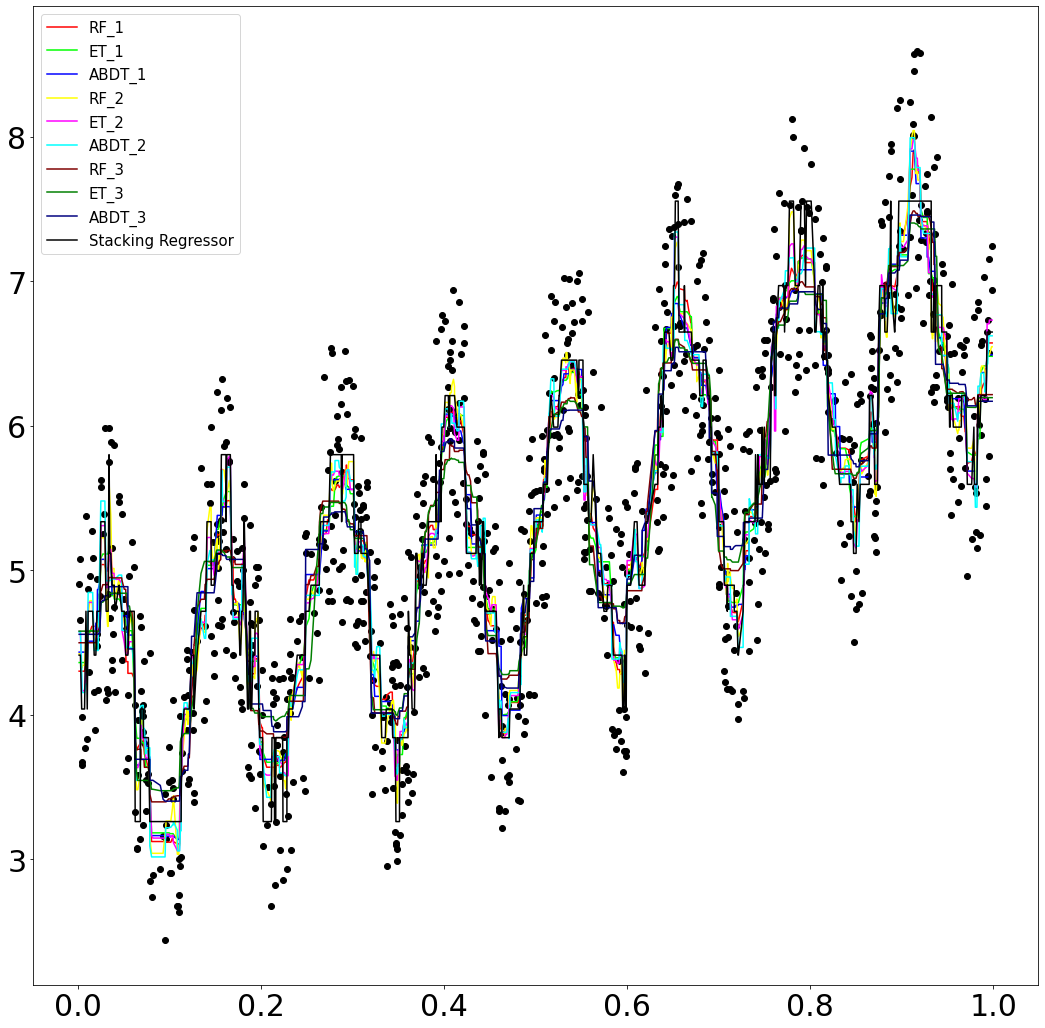

In [16]:
color=["#FF0000","#00FF00","#0000FF","#FFFF00","#FF00FF","#00FFFF","#7F0000","#007F00","#00007F"]
label=["RF_1","ET_1","ABDT_1","RF_2","ET_2","ABDT_2","RF_3","ET_3","ABDT_3"]
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x,y,"ko",markersize=6)
sort_x=np.sort(x)
sort_x_index=np.argsort(x)
for i in range(0,9):
    plt.plot(sort_x,NEW_X[sort_x_index,i],color[i],label=label[i])
plt.plot(sort_x,y_train_Final[sort_x_index],"k",label="Stacking Regressor")
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=15)
plt.show()